In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [60]:
df = pd.read_csv('./dataset/brca_metabric_clinical_data.tsv', sep='\t')
df.to_csv('./dataset/brca.csv')

In [61]:
df.drop(columns=['Study ID', 'Patient ID', 'Sample ID'], inplace=True)

In [67]:
n_nan_columns = df.isnull().sum()
print(n_nan_columns.head(50))

Age at Diagnosis                  0
Type of Breast Surgery            0
Cancer Type                       0
Cancer Type Detailed              0
Cellularity                       0
Chemotherapy                      0
Pam50 + Claudin-low subtype       0
Cohort                            0
ER status measured by IHC         0
ER Status                         0
Neoplasm Histologic Grade         0
HER2 status measured by SNP6      0
HER2 Status                       0
Tumor Other Histologic Subtype    0
Hormone Therapy                   0
Inferred Menopausal State         0
Integrative Cluster               0
Primary Tumor Laterality          0
Lymph nodes examined positive     0
Mutation Count                    0
Nottingham prognostic index       0
Oncotree Code                     0
Overall Survival (Months)         0
Overall Survival Status           0
PR Status                         0
Radio Therapy                     0
Relapse Free Status (Months)      0
Relapse Free Status         

In [66]:
df.dropna(inplace=True)

In [68]:
df

,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
1,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,YES,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,0:LIVING,Positive,YES,83.52,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
4,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,YES,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,1:DECEASED,Positive,YES,18.55,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease
5,78.77,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,NO,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,YES,Post,7,Left,0.0,4.0,4.062,IDC,7.800000,1:DECEASED,Positive,YES,2.89,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,5.230071,31.0,4.0,Died of Disease
10,86.41,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,NO,LumB,1.0,Positve,Positive,3.0,GAIN,Negative,Ductal/NST,YES,Post,9,Right,1.0,4.0,5.032,IDC,36.566667,1:DECEASED,Negative,YES,36.09,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,5.230071,16.0,2.0,Died of Other Causes
11,84.22,MASTECTOMY,Breast Cancer,Breast Invasive Lobular Carcinoma,High,NO,Her2,1.0,Negative,Positive,2.0,LOSS,Negative,Lobular,NO,Post,3,Left,0.0,5.0,3.056,ILC,36.266667,1:DECEASED,Negative,NO,35.79,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,6.537589,28.0,2.0,Died of Disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,71.22,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,NO,LumA,5.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,YES,Post,3,Left,4.0,11.0,5.060,MDLC,85.000000,1:DECEASED,Positive,NO,83.88,0:Not Recurred,1,Primary,Female,ER+/HER2- Low Prolif,14.382695,30.0,2.0,Died of Other Causes
1698,70.65,BREAST CONSERVING,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,NO,LumB,5.0,Positve,Positive,1.0,NEUTRAL,Negative,Mixed,NO,Post,8,Left,0.0,9.0,2.040,MDLC,201.166667,0:LIVING,Positive,YES,198.52,0:Not Recurred,1,Primary,Female,ER+/HER2- Low Prolif,11.767659,20.0,1.0,Living
1700,75.62,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,Basal,5.0,Negative,Negative,3.0,GAIN,Negative,Ductal/NST,NO,Post,10,Right,0.0,4.0,4.040,IDC,105.200000,1:DECEASED,Negative,NO,103.82,0:Not Recurred,1,Primary,Female,ER-/HER2-,5.230071,20.0,1.0,Died of Other Causes
1702,52.84,BREAST CONSERVING,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,Normal,5.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,NO,Post,8,Right,6.0,5.0,5.040,MDLC,200.333333,0:LIVING,Positive,YES,197.70,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,6.537589,20.0,2.0,Living


In [70]:
X = df.iloc[:, :-2]
y = df.iloc[:, -2]

In [73]:
X = pd.get_dummies(X)

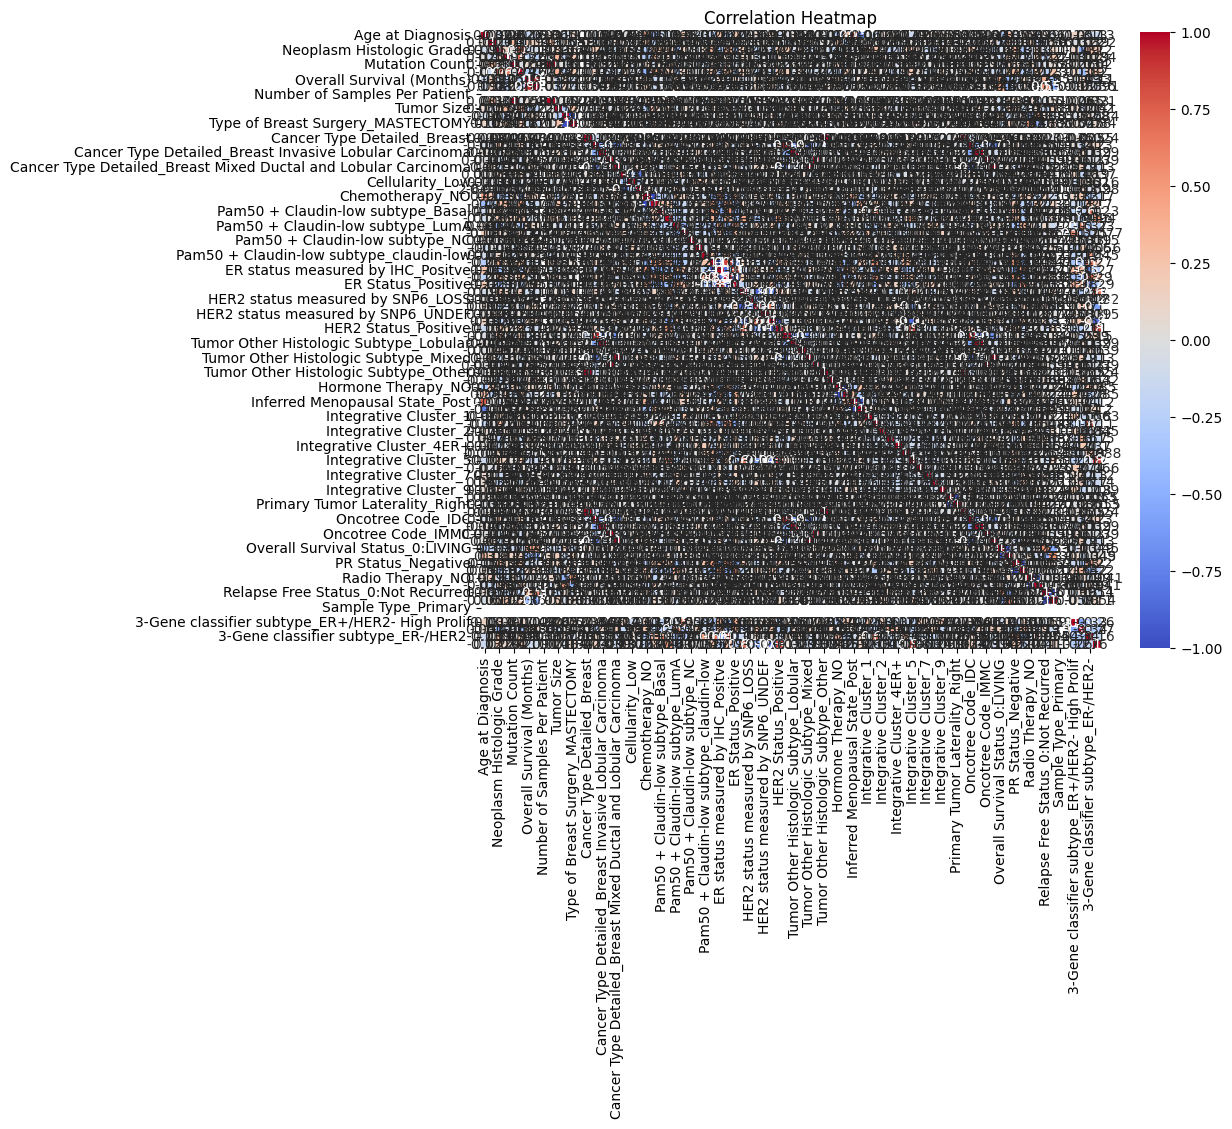

In [74]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()